In [1]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.stats import kurtosis, skew, entropy

In [2]:
fs = 100
sampling_rate = 100
duration = 10

data_train = np.load('../Data/NewData/simu_20000_0.1_90_140_train_NoRR.npy')
data_test = np.load('../Data/NewData/simu_10000_0.1_141_178_test_NoRR.npy')

signals_train, S_train, D_train = data_train[:, :1000], data_train[:, -2], data_train[:, -1]
signals_test, S_test, D_test = data_test[:, :1000], data_test[:, -2], data_test[:, -1]


# print(signals_test.shape, S_train.shape, D_test[0])
# D_test, S_test

# plt.plot(signals_train[0])
# plt.plot(signals_test[0])


In [3]:
def update_array(a, data_tmp):
    i = 0
    while i < len(a) - 2:
        if data_tmp[a[i]] < data_tmp[a[i + 1]] < data_tmp[a[i + 2]]:
            a = np.delete(a, i)
        elif data_tmp[a[i]] > data_tmp[a[i + 1]] > data_tmp[a[i + 2]]:
            a = np.delete(a, i + 2)
        else:
            i += 1
    return a

def get_peaks(data_tmp, duration, sampling_rate):
    max = np.max(data_tmp)
    data_tmp = data_tmp / max

    t = np.linspace(0, duration, duration * sampling_rate)
    signal = data_tmp

    peak_indices, _ = find_peaks(signal) 

    t_peaks = t[peak_indices] 
    peak_values = signal[peak_indices]  
    interpolation_func = interp1d(t_peaks, peak_values, kind='linear', bounds_error=False, fill_value=0)
    envelope = interpolation_func(t)

    peaks2, _ = find_peaks(envelope, distance=10)

    peaks2 = update_array(peaks2, data_tmp)
    if len(peaks2) % 2 != 0:
        peaks2 = np.delete(peaks2, len(peaks2) - 1)

    return peaks2

# for i in range(10):
    # plt.figure()
    # peaks = get_peaks(signals_train[i], 10, 100)
    # plt.plot(signals_train[i])
    # plt.scatter(peaks, signals_train[i][peaks])

In [8]:

def delete_unique(a):
    mean = np.mean(a)
    std = np.std(a)
    # 设置阈值
    threshold = 1
    # 使用布尔索引删除特殊值
    filtered_a = a[np.abs(a - mean) <= threshold * std]
    return filtered_a

def get_mag_0(peaks2, data_tmp):
    return np.mean(data_tmp[peaks2[::2]])

def get_mag_1(peaks2, data_tmp):
    return np.mean(data_tmp[peaks2[1::2]])

def get_features(data_tmp, peaks2):
    max = np.max(data_tmp)
    min = np.min(data_tmp)
    data_tmp_raw = data_tmp
    data_tmp = data_tmp / max

    fs = 100

    data_tmp = data_tmp_raw / max

    diff_12 = peaks2[1::2] - peaks2[0::2]
    diff_21 = peaks2[2::2] - peaks2[1:-1:2]
    diff_22 = peaks2[2::2] - peaks2[:-2:2]

    diff_12 = delete_unique(diff_12)
    diff_21 = delete_unique(diff_21)
    diff_22 = delete_unique(diff_22)

    m_12 = np.mean(diff_12)
    m_21 = np.mean(diff_21)
    m_22 = np.mean(diff_22)

    mag_0 = get_mag_0(peaks2, data_tmp_raw)
    mag_1 = get_mag_1(peaks2, data_tmp_raw)

    diff_12_mean = np.mean(diff_12)
    diff_21_mean = np.mean(diff_21)

    if diff_12_mean < diff_21_mean:
        diff_min = diff_12_mean
    else:
        diff_min = diff_21_mean

    diff_min = int(diff_min / 2)

    kurt = []
    for i in range(1, len(peaks2) - 1):
        seg = data_tmp[peaks2[i] - diff_min:peaks2[i] + diff_min]
        if len(seg) > 0:
            kurt.append(kurtosis(seg))

    kurt2 = kurt[::2]
    kurt1 = kurt[1::2]

    kurt2_mean = np.mean(kurt2)
    kurt1_mean = np.mean(kurt1)

    sk = []
    for i in range(1, len(peaks2) - 1):
        seg = data_tmp[peaks2[i] - diff_min:peaks2[i] + diff_min]
        if len(seg) > 0:
            sk.append(skew(seg))

    skew2 = sk[::2]
    skew1 = sk[1::2]

    skew2_mean = np.mean(skew2)
    skew1_mean = np.mean(skew1)

    features = np.array([m_12, m_21, m_22, m_12 / m_21, mag_0, mag_1, mag_0 - mag_1, mag_0 / mag_1, kurt2_mean, kurt1_mean, skew1_mean, skew2_mean])

    return features


signals_train[1701] = signals_train[0]

# features_train, features_test = [], []
# for i, signal in enumerate(signals_train):
    # peaks = get_peaks(signal, duration, sampling_rate)
    # if len(peaks) <= 14: 
        # continue
    # features = get_features(signal, peaks)
    # features_train.append(features)

# features_train = np.array(features_train)
# np.save('../Data/NewData/NoRR_features_train_10.npy', features_train)

# for signal in signals_test:
    # print(i)
    # peaks = get_peaks(signal, duration, sampling_rate)
    # if len(peaks) <= 14:
        # continue
    # features = get_features(signal, peaks)
    # features_test.append(features)

# features_test = np.array(features_test)

# np.save('../Data/NewData/NoRR_features_test_10.npy', features_test)

New_S_train, New_S_test = [], []
New_D_train, New_D_test = [], []

for i, signal in enumerate(signals_train):
    peaks = get_peaks(signal, duration, sampling_rate)
    if len(peaks) > 14:
        New_S_train.append(S_train[i]) 
        New_D_train.append(D_train[i])

New_S_train = np.array(New_S_train)
New_D_train = np.array(New_D_train)
# New_D_train.shape, New_S_train.shape, features_train.shape

for i, signal in enumerate(signals_test):
    peaks = get_peaks(signal, duration, sampling_rate)
    if len(peaks) > 14:
        New_S_test.append(S_test[i]) 
        New_D_test.append(D_test[i])

New_S_test = np.array(New_S_test)
New_D_test = np.array(New_D_test)

S_train = New_S_train
S_test = New_S_test
D_train = New_D_train
D_test = New_D_test
# New_D_test.shape, New_S_test.shape, features_test.shape

# np.save('../Data/NewData/NoRR_S_train.npy', )


In [4]:

features_train = np.load('../Data/NewData/NoRR_features_train_10.npy')
features_test = np.load('../Data/NewData/NoRR_features_test_10.npy')



0.2187540713665626
-0.225000595349216
-0.0002539604098244926
1.0
0.07469389969229746
-0.16953552157693388
0.2309026181296418
0.1313228976789414
0.19492507095301892
0.21274607632341244
0.09580605190298824
0.11862282993828746


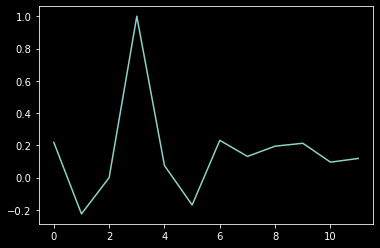

In [31]:
p1s = []
p2s = []
for i in range(len(features_train[0])):
    p1 = np.corrcoef(features_train[:, i], features_train[:, 3])[0, 1]
    print(p1)
    p1s.append(p1)
    # p2 = np.corrcoef(features_train[:, i], D_train)[0, 1]
    # p2s.append(p2)
    # print(p1, p2)
plt.plot(p1s)



In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

BATCH_SIZE = 16

input_features = [4, 7, 8, 9, 10, 11]
input_size = len(input_features)

scaler = MinMaxScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

features_train_ft = torch.FloatTensor(features_train[:, input_features])
features_test_ft = torch.FloatTensor(features_test[:, input_features])

S_train_ft = torch.FloatTensor(S_train)
S_test_ft = torch.FloatTensor(S_test)
D_train_ft = torch.FloatTensor(D_train)
D_test_ft = torch.FloatTensor(D_test)

train_dataset_S = TensorDataset(features_train_ft, S_train_ft)
train_dataset_D = TensorDataset(features_train_ft, D_train_ft)
test_dataset_S = TensorDataset(features_test_ft, S_test_ft)
test_dataset_D = TensorDataset(features_test_ft, D_test_ft)

train_dataset = train_dataset_S
test_dataset = test_dataset_S

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleMLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size1)
        self.hidden2 = nn.Linear(hidden_size1, hidden_size1)
        self.hidden3 = nn.Linear(hidden_size1, hidden_size1)
        self.hidden4 = nn.Linear(hidden_size1, hidden_size1)
        self.hidden5 = nn.Linear(hidden_size1, hidden_size2)
        self.output = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.hidden1(x))
        x = self.sigmoid(self.hidden2(x))
        x = self.sigmoid(self.hidden3(x))
        x = self.hidden4(x)
        x = self.hidden5(x)
        x = self.output(x)
        return x


# input_size = 23
hidden_size1 = input_size 
hidden_size2 = hidden_size1 // 2
output_size = 1


model = SimpleMLP(input_size, hidden_size1, hidden_size2, output_size)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000

for epoch in range(num_epochs):
    losses = []
    for data, label in train_loader:
        outputs = model(data)
        loss = criterion(outputs, label)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses):.4f}')


    test_losses = []
    for data, label in test_loader:
        outputs = model(data)
        loss = criterion(outputs, label)
        test_losses.append(loss.item()) 

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(test_losses):.4f}')

#
# with torch.no_grad():
    # predictions = model(x_test)

# print("Predictions:", predictions)


d:\ANACONDA\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
d:\ANACONDA\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
d:\ANACONDA\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, 

Epoch [5/1000], Loss: 10.3518
Epoch [5/1000], Loss: 10.3364
Epoch [10/1000], Loss: 10.3310
Epoch [10/1000], Loss: 10.3127
Epoch [15/1000], Loss: 10.3243
Epoch [15/1000], Loss: 10.2446
Epoch [20/1000], Loss: 10.3068
Epoch [20/1000], Loss: 10.2934
Epoch [25/1000], Loss: 10.3313
Epoch [25/1000], Loss: 10.2733
Epoch [30/1000], Loss: 10.3268
Epoch [30/1000], Loss: 10.2476
Epoch [35/1000], Loss: 10.3127
Epoch [35/1000], Loss: 10.4085
Epoch [40/1000], Loss: 10.3284
Epoch [40/1000], Loss: 10.4849
Epoch [45/1000], Loss: 10.3277
Epoch [45/1000], Loss: 10.3084
Epoch [50/1000], Loss: 10.3318
Epoch [50/1000], Loss: 10.2427
Epoch [55/1000], Loss: 10.3219
Epoch [55/1000], Loss: 10.3879


KeyboardInterrupt: 

In [23]:
# features_train_ft S_train
p1s = []
p2s = []
# for i in range(len(features_train[7])):
p1 = np.corrcoef(features_train[:, 7], D_train)[0, 1]
print(p1)

# for i in range(len(features_test_ft[0])):
print(np.corrcoef(features_test[:, 7], D_test)[0, 1])

-0.6344310010192135
-0.5988296894209152
